# FITS image import

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

In [2]:
# Download the example FITS files used by this example:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

image_file = get_pkg_data_filename('tutorials/FITS-images/HorseHead.fits')

In [3]:
#display the structure of the file:
fits.info(image_file)

Filename: /Users/hakkeray/.astropy/cache/download/py3/2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


In [4]:
# image information is located in the Primary HDU, also known as extension 0. 
image_data = fits.getdata(image_file, ext=0)

In [5]:
print(image_data.shape)

(893, 891)


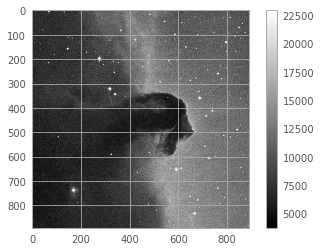

In [6]:
plt.figure()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

# Determining and plotting the altitude/azimuth of a celestial object

In [7]:
# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_obs-planning.html#sphx-glr-generated-examples-coordinates-plot-obs-planning-py

import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x11ed6a240>

In [8]:
#Import the packages necessary for finding coordinates and making coordinate transformations

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [9]:
#Get the coordinates of M33:

m33 = SkyCoord.from_name('M33')

In [10]:
m33

<SkyCoord (ICRS): (ra, dec) in deg
    (23.4621, 30.6599417)>

In [11]:
# Use astropy.coordinates.EarthLocation to provide the location of Bear Mountain 
# set the time to 11pm EDT on 2012 July 12:

bear_mountain = EarthLocation(lat=41.3*u.deg, lon=-74*u.deg, height=390*u.m)
utcoffset = -4*u.hour  # Eastern Daylight Time
time = Time('2012-7-12 23:00:00') - utcoffset

# astropy.coordinates.EarthLocation.get_site_names and get_site_names can be used 
# to get locations of major observatories.



In [12]:
#Use astropy.coordinates to find the Alt, Az coordinates of M33 at as observed from Bear Mountain at 11pm on 2012 July 12.

m33altaz = m33.transform_to(AltAz(obstime=time,location=bear_mountain))
print("M33's Altitude = {0.alt:.2}".format(m33altaz))

M33's Altitude = 0.13 deg


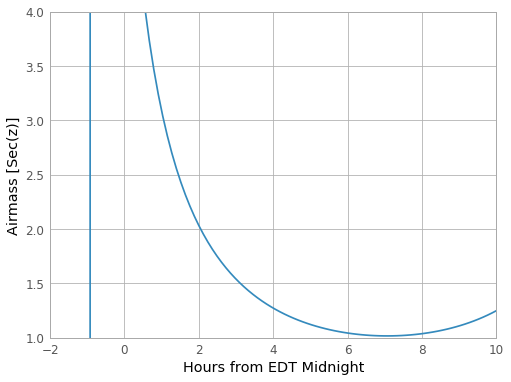

In [14]:
#Find the alt,az coordinates of M33 at 100 times evenly spaced between 10pm and 7am EDT:

midnight = Time('2012-7-13 00:00:00') - utcoffset
delta_midnight = np.linspace(-2, 10, 100)*u.hour
frame_July13night = AltAz(obstime=midnight+delta_midnight,
                          location=bear_mountain)

m33altazs_July13night = m33.transform_to(frame_July13night)

#convert alt, az to airmass with secz attribute:

m33airmasss_July13night = m33altazs_July13night.secz

#Plot the airmass as a function of time:

plt.plot(delta_midnight, m33airmasss_July13night)
plt.xlim(-2, 10)
plt.ylim(1, 4)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Airmass [Sec(z)]')
plt.show()

In [15]:
#Use get_sun to find the location of the Sun at 1000 evenly spaced times between noon 
# on July 12 and noon on July 13:

from astropy.coordinates import get_sun
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times_July12_to_13 = midnight + delta_midnight
frame_July12_to_13 = AltAz(obstime=times_July12_to_13, location=bear_mountain)
sunaltazs_July12_to_13 = get_sun(times_July12_to_13).transform_to(frame_July12_to_13)


In [17]:
#Do the same with get_moon to find when the moon is up. Be aware that this will need to download a 10MB file from the internet to get a precise location of the moon.

from astropy.coordinates import get_moon
moon_July12_to_13 = get_moon(times_July12_to_13)
moonaltazs_July12_to_13 = moon_July12_to_13.transform_to(frame_July12_to_13)


In [18]:
#Find the alt,az coordinates of M33 at those same times:

m33altazs_July12_to_13 = m33.transform_to(frame_July12_to_13)

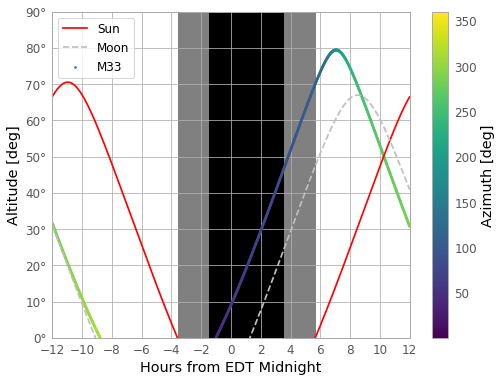

In [19]:
#Make a  figure illustrating nighttime and the altitudes of M33 and the Sun over that time:

plt.plot(delta_midnight, sunaltazs_July12_to_13.alt, color='r', label='Sun')
plt.plot(delta_midnight, moonaltazs_July12_to_13.alt, color=[0.75]*3, ls='--', label='Moon')
plt.scatter(delta_midnight, m33altazs_July12_to_13.alt,
            c=m33altazs_July12_to_13.az, label='M33', lw=0, s=8,
            cmap='viridis')
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sunaltazs_July12_to_13.alt < -0*u.deg, color='0.5', zorder=0)
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sunaltazs_July12_to_13.alt < -18*u.deg, color='k', zorder=0)
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc='upper left')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2-12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Altitude [deg]')
plt.show()

# Transforming positions and velocities to and from a Galactocentric frame

how to use and customize the Galactocentric frame to transform Heliocentric sky positions, distance, proper motions, and radial velocities to a Galactocentric, Cartesian frame, and the same in reverse.

The main configurable parameters of the Galactocentric frame control the position and velocity of the solar system barycenter within the Galaxy. These are specified by setting the ICRS coordinates of the Galactic center, the distance to the Galactic center (the sun-galactic center line is always assumed to be the x-axis of the Galactocentric frame), and the Cartesian 3-velocity of the sun in the Galactocentric frame.

In [21]:
# Import the necessary astropy subpackages

import astropy.coordinates as coord
import astropy.units as u


In [22]:
#Let’s first define a barycentric coordinate and velocity in the ICRS frame. We’ll use the data for the star HD 39881 from the Simbad database:

c1 = coord.ICRS(ra=89.014303*u.degree, dec=13.924912*u.degree,
                distance=(37.59*u.mas).to(u.pc, u.parallax()),
                pm_ra_cosdec=372.72*u.mas/u.yr,
                pm_dec=-483.69*u.mas/u.yr,
                radial_velocity=0.37*u.km/u.s)

In [23]:
# This is a high proper-motion star; suppose we’d like to transform its position and velocity to a Galactocentric frame to see if it has a large 3D velocity as well. To use the Astropy default solar position and motion parameters, we can simply do:

gc1 = c1.transform_to(coord.Galactocentric)

#From here, we can access the components of the resulting Galactocentric instance to see the 3D Cartesian velocity components:

print(gc1.v_x, gc1.v_y, gc1.v_z)

28.461887707012632 km / s 157.93916086163026 km / s 17.651893131558683 km / s


In [24]:
#The default parameters for the Galactocentric frame are detailed in the linked documentation, but we can modify the most commonly changes values using the keywords galcen_distance, galcen_v_sun, and z_sun which set the sun-Galactic center distance, the 3D velocity vector of the sun, and the height of the sun above the Galactic midplane, respectively. The velocity of the sun must be specified as a CartesianDifferential instance, as in the example below. Note that, as with the positions, the Galactocentric frame is a right-handed system - the x-axis is positive towards the Galactic center, so v_x is opposite of the Galactocentric radial velocity:

v_sun = coord.CartesianDifferential([11.1, 244, 7.25]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=0*u.pc)
#We can then transform to this frame instead, with our custom parameters:

gc2 = c1.transform_to(gc_frame)
print(gc2.v_x, gc2.v_y, gc2.v_z)

28.42795836058219 km / s 169.69916086163028 km / s 17.70831652443232 km / s


In [25]:
#It’s sometimes useful to specify the solar motion using the proper motion of Sgr A* instead of Cartesian velocity components. With an assumed distance, we can convert proper motion components to Cartesian velocity components using astropy.units:

galcen_distance = 8*u.kpc
pm_gal_sgrA = [-6.379, -0.202] * u.mas/u.yr # from Reid & Brunthaler 2004
vy, vz = -(galcen_distance * pm_gal_sgrA).to(u.km/u.s, u.dimensionless_angles())

#We still have to assume a line-of-sight velocity for the Galactic center, which we will again take to be 11 km/s:

vx = 11.1 * u.km/u.s

gc_frame2 = coord.Galactocentric(galcen_distance=galcen_distance,
                                 galcen_v_sun=coord.CartesianDifferential(vx, vy, vz),
                                 z_sun=0*u.pc)
gc3 = c1.transform_to(gc_frame2)
print(gc3.v_x, gc3.v_y, gc3.v_z)

28.42795836058219 km / s 167.61484955476874 km / s 18.118916793442192 km / s


In [27]:
# The transformations also work in the opposite direction. This can be useful for transforming simulated or theoretical data to observable quantities. As an example, we’ll generate 4 theoretical circular orbits at different Galactocentric radii with the same circular velocity, and transform them to Heliocentric coordinates:

ring_distances = np.arange(10, 25+1, 5) * u.kpc
circ_velocity = 220 * u.km/u.s

phi_grid = np.linspace(90, 270, 512) * u.degree # grid of azimuths
ring_rep = coord.CylindricalRepresentation(
    rho=ring_distances[:,np.newaxis],
    phi=phi_grid[np.newaxis],
    z=np.zeros_like(ring_distances)[:,np.newaxis])

angular_velocity = (-circ_velocity / ring_distances).to(u.mas/u.yr,
                                                        u.dimensionless_angles())
ring_dif = coord.CylindricalDifferential(
    d_rho=np.zeros(phi_grid.shape)[np.newaxis]*u.km/u.s,
    d_phi=angular_velocity[:,np.newaxis],
    d_z=np.zeros(phi_grid.shape)[np.newaxis]*u.km/u.s
)

ring_rep = ring_rep.with_differentials(ring_dif)
gc_rings = coord.Galactocentric(ring_rep)


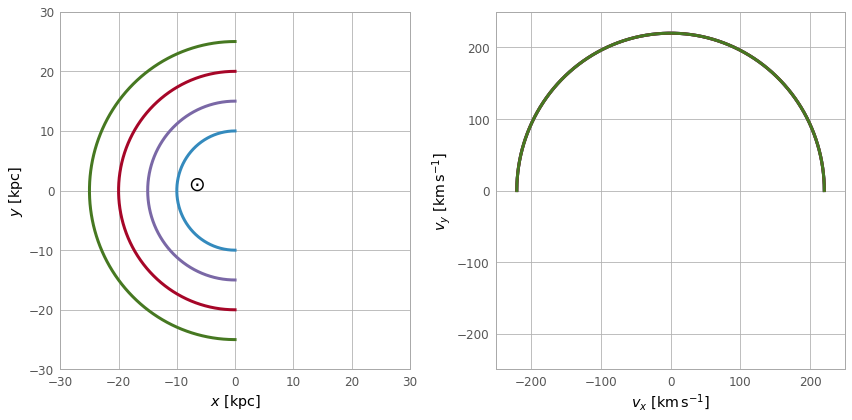

In [29]:
#First, let’s visualize the geometry in Galactocentric coordinates. Here are the positions and velocities of the rings; note that in the velocity plot, the velocities of the 4 rings are identical and thus overlaid under the same curve:

fig,axes = plt.subplots(1, 2, figsize=(12,6))

# Positions
axes[0].plot(gc_rings.x.T, gc_rings.y.T, marker='None', linewidth=3)
axes[0].text(-8., 0, r'$\odot$', fontsize=20)

axes[0].set_xlim(-30, 30)
axes[0].set_ylim(-30, 30)

axes[0].set_xlabel('$x$ [kpc]')
axes[0].set_ylabel('$y$ [kpc]')

# Velocities
axes[1].plot(gc_rings.v_x.T, gc_rings.v_y.T, marker='None', linewidth=3)

axes[1].set_xlim(-250, 250)
axes[1].set_ylim(-250, 250)

axes[1].set_xlabel('$v_x$ [{0}]'.format((u.km/u.s).to_string("latex_inline")))
axes[1].set_ylabel('$v_y$ [{0}]'.format((u.km/u.s).to_string("latex_inline")))

fig.tight_layout()

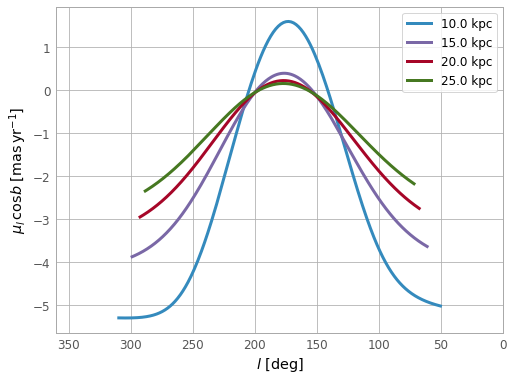

In [30]:
#Now we can transform to Galactic coordinates and visualize the rings in observable coordinates:

gal_rings = gc_rings.transform_to(coord.Galactic)

fig,ax = plt.subplots(1, 1, figsize=(8,6))
for i in range(len(ring_distances)):
    ax.plot(gal_rings[i].l.degree, gal_rings[i].pm_l_cosb.value,
            label=str(ring_distances[i]), marker='None', linewidth=3)

ax.set_xlim(360, 0)

ax.set_xlabel('$l$ [deg]')
ax.set_ylabel(r'$\mu_l \, \cos b$ [{0}]'.format((u.mas/u.yr).to_string('latex_inline')))

ax.legend()

# Create new coordinate class

In [32]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

#The first step is to create a new class, which we’ll call Sagittarius and make it a subclass of BaseCoordinateFrame:

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `~astropy.coordinates.Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `~astropy.coordinates.Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }

In [33]:
SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree

# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)



#Since we already constructed the transformation (rotation) matrix above, and the inverse of a rotation matrix is just its transpose, the required transformation functions are very simple:

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX


#The decorator @frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius) registers this function on the frame_transform_graph as a coordinate transformation. Inside the function, we simply return the previously defined rotation matrix.

#We then register the inverse transformation by using the transpose of the rotation matrix (which is faster to compute than the inverse):

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)

In [35]:
icrs = coord.ICRS(280.161732*u.degree, 11.91934*u.degree)
sgr = icrs.transform_to(Sagittarius)
print(sgr)

<Sagittarius Coordinate: (Lambda, Beta) in deg
    (346.81830652, -39.28360407)>


In [40]:
#Or, to transform from the Sagittarius frame to ICRS coordinates (in this case, a line along the Sagittarius x-y plane):

sgr = Sagittarius(Lambda=np.linspace(0, 2*np.pi, 128)*u.radian,
                  Beta=np.zeros(128)*u.radian)
icrs = sgr.transform_to(coord.ICRS)
#print(icrs)

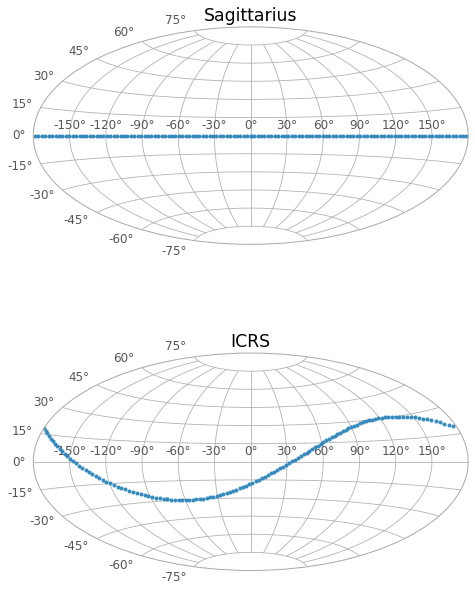

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10),
                         subplot_kw={'projection': 'aitoff'})

axes[0].set_title("Sagittarius")
axes[0].plot(sgr.Lambda.wrap_at(180*u.deg).radian, sgr.Beta.radian,
             linestyle='none', marker='.')

axes[1].set_title("ICRS")
axes[1].plot(icrs.ra.wrap_at(180*u.deg).radian, icrs.dec.radian,
             linestyle='none', marker='.')

plt.show()

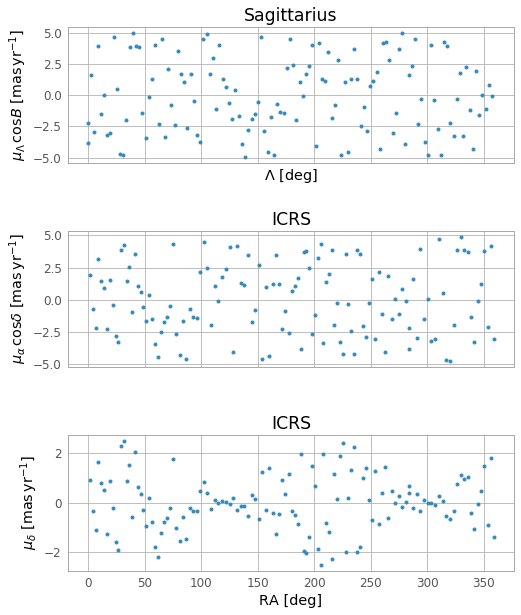

In [42]:
# This particular transformation is just a spherical rotation, which is a special case of an Affine transformation with no vector offset. The transformation of velocity components is therefore natively supported as well:

sgr = Sagittarius(Lambda=np.linspace(0, 2*np.pi, 128)*u.radian,
                  Beta=np.zeros(128)*u.radian,
                  pm_Lambda_cosBeta=np.random.uniform(-5, 5, 128)*u.mas/u.yr,
                  pm_Beta=np.zeros(128)*u.mas/u.yr)
icrs = sgr.transform_to(coord.ICRS)
#print(icrs)

fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

axes[0].set_title("Sagittarius")
axes[0].plot(sgr.Lambda.degree,
             sgr.pm_Lambda_cosBeta.value,
             linestyle='none', marker='.')
axes[0].set_xlabel(r"$\Lambda$ [deg]")
axes[0].set_ylabel(r"$\mu_\Lambda \, \cos B$ [{0}]"
                   .format(sgr.pm_Lambda_cosBeta.unit.to_string('latex_inline')))

axes[1].set_title("ICRS")
axes[1].plot(icrs.ra.degree, icrs.pm_ra_cosdec.value,
             linestyle='none', marker='.')
axes[1].set_ylabel(r"$\mu_\alpha \, \cos\delta$ [{0}]"
                   .format(icrs.pm_ra_cosdec.unit.to_string('latex_inline')))

axes[2].set_title("ICRS")
axes[2].plot(icrs.ra.degree, icrs.pm_dec.value,
             linestyle='none', marker='.')
axes[2].set_xlabel("RA [deg]")
axes[2].set_ylabel(r"$\mu_\delta$ [{0}]"
                   .format(icrs.pm_dec.unit.to_string('latex_inline')))

plt.show();
